<a href="https://colab.research.google.com/github/LampsteR/Stock_Prediction/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Fetching data for INFY.NS...


[*********************100%***********************]  1 of 1 completed


Data shape: (2582, 5)
Date range: 2015-01-01 00:00:00 to 2025-06-18 00:00:00
Preparing data for LSTM...
Training data shape: X_train: (2017, 60, 5), y_train: (2017,)
Testing data shape: X_test: (505, 60, 5), y_test: (505,)
Building LSTM model...
Model Architecture:
Input Size: 5
Hidden Size: 256
Number of Layers: 3
Output Size: 1
Total Parameters: 1,322,241
Trainable Parameters: 1,322,241
Training LSTM model...
Epoch [10/1000], Train Loss: 0.000865, Val Loss: 0.002145
Epoch [20/1000], Train Loss: 0.000574, Val Loss: 0.003000
Epoch [30/1000], Train Loss: 0.000628, Val Loss: 0.000663
Epoch [40/1000], Train Loss: 0.000600, Val Loss: 0.000832
Epoch [50/1000], Train Loss: 0.000425, Val Loss: 0.000629
Epoch [60/1000], Train Loss: 0.000435, Val Loss: 0.000584
Epoch [70/1000], Train Loss: 0.000515, Val Loss: 0.000601
Epoch [80/1000], Train Loss: 0.000535, Val Loss: 0.000569
Epoch [90/1000], Train Loss: 0.000521, Val Loss: 0.000839
Epoch [100/1000], Train Loss: 0.000375, Val Loss: 0.001068
Epoc

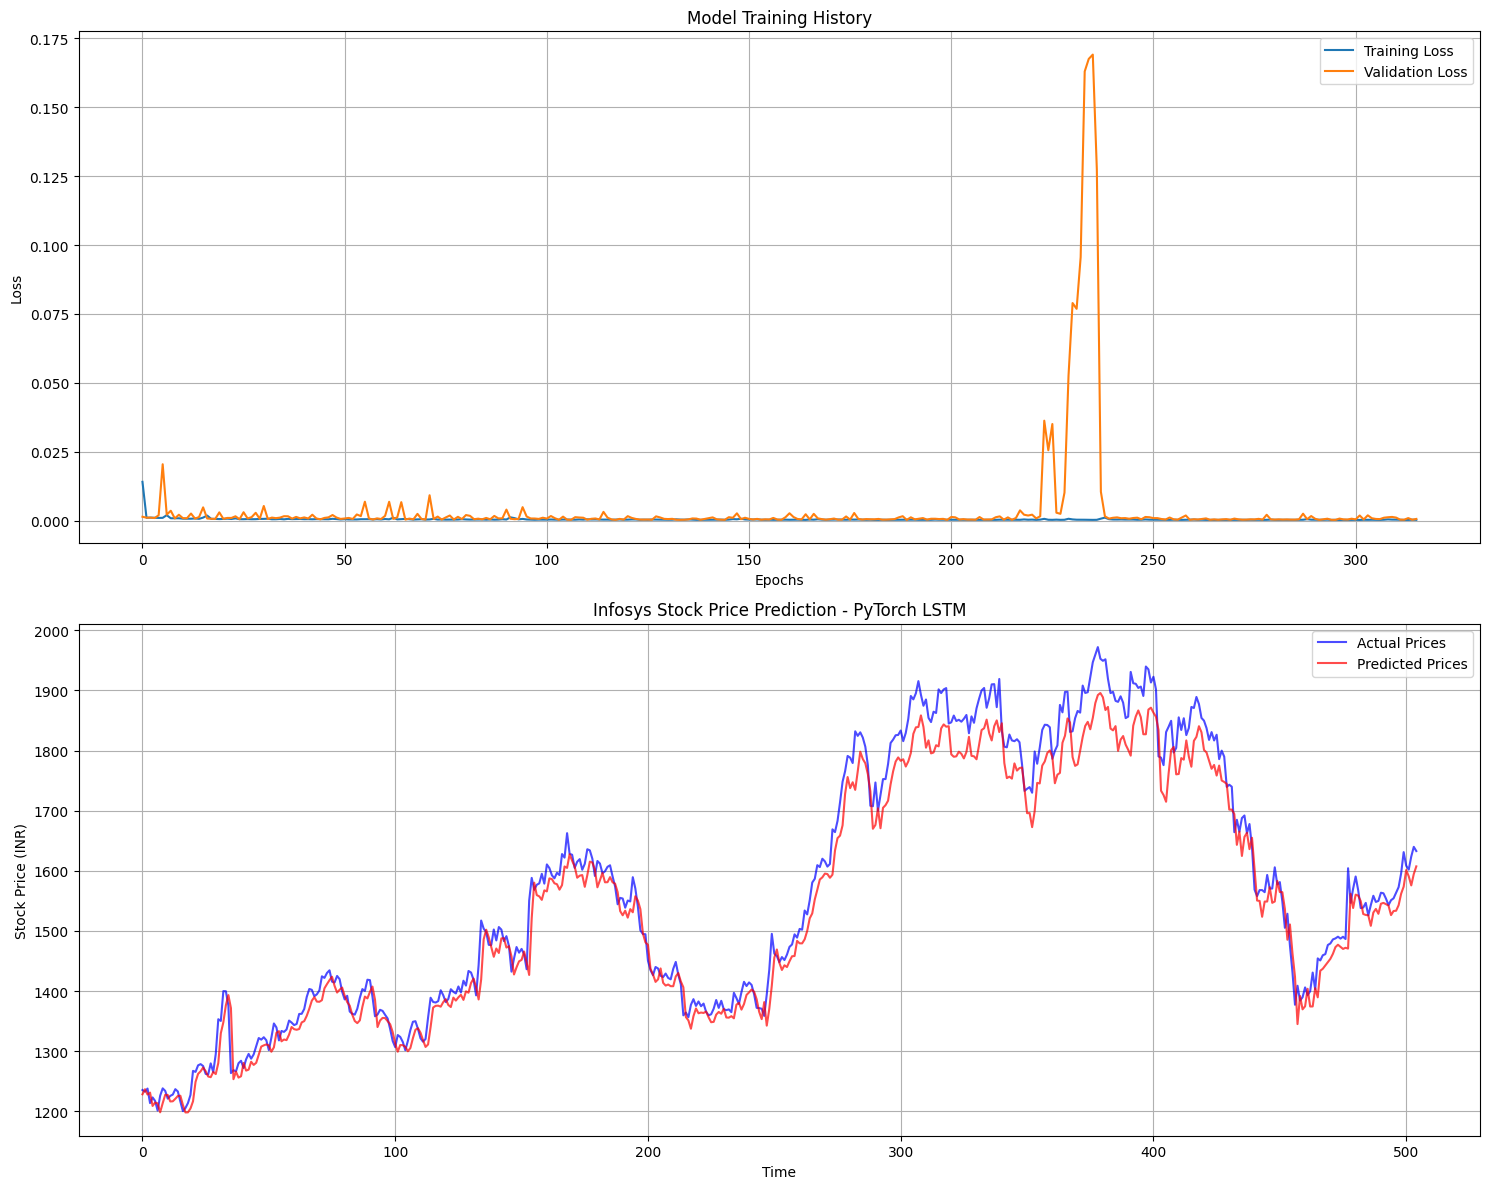

Predicting stock price for next 1 day(s)...

Predicted closing price for next trading day: ₹1612.09
Predicting stock price for next 5 day(s)...

Predicted closing prices for next 5 trading days:
Day 1: ₹1612.09
Day 2: ₹1604.75
Day 3: ₹1598.97
Day 4: ₹1597.15
Day 5: ₹1597.23


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



class LSTMModel(nn.Module):
    """
    LSTM Neural Network for Stock Price Prediction
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.25):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout_rate)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step
        out = out[:, -1, :]

        # Apply dropout
        out = self.dropout(out)

        # Final linear layer
        out = self.fc(out)

        return out

class EarlyStopping:#Checkpoint Creation
    """
    Early stopping to stop training when validation loss doesn't improve
    """
    def __init__(self, patience=250, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

class InfosysStockPredictor:
    def __init__(self, symbol='INFY.NS', lookback_days=60):
        """
        Initialize the stock predictor

        Args:
            symbol (str): Stock symbol for Infosys NSE (INFY.NS)
            lookback_days (int): Number of previous days to use for prediction
        """
        self.symbol = symbol
        self.lookback_days = lookback_days
        self.scaler = MinMaxScaler(feature_range=(0, 1))#Normalisation
        self.model = None
        self.data = None
        self.scaled_data = None
        self.device = device

    def fetch_data(self, start_date='2015-01-01', end_date=None):
        """
        Fetch stock data from Yahoo Finance

        Args:
            start_date (str): Start date for data fetching
            end_date (str): End date for data fetching (None for current date)
        """
        print(f"Fetching data for {self.symbol}...")
        self.data = yf.download(self.symbol, start=start_date, end=end_date)

        # Clean column names (remove multi-level indexing if present)
        if isinstance(self.data.columns, pd.MultiIndex):
            self.data.columns = self.data.columns.droplevel(1)

        # Select relevant features: Open, High, Low, Close, Volume
        features = ['Open', 'High', 'Low', 'Close', 'Volume']
        self.data = self.data[features].dropna()

        print(f"Data shape: {self.data.shape}")
        print(f"Date range: {self.data.index[0]} to {self.data.index[-1]}")

        return self.data

    def prepare_data(self, target_column='Close'):
        """
        Prepare data for LSTM training

        Args:
            target_column (str): Column to predict (default: 'Close')
        """
        print("Preparing data for LSTM...")

        # Scale the data
        self.scaled_data = self.scaler.fit_transform(self.data)

        # Find target column index
        target_idx = list(self.data.columns).index(target_column)

        X, y = [], []

        # Create sequences of lookback_days for prediction
        for i in range(self.lookback_days, len(self.scaled_data)):
            X.append(self.scaled_data[i-self.lookback_days:i])  # Previous 60 days of all features
            y.append(self.scaled_data[i, target_idx])  # Next day's closing price

        X, y = np.array(X), np.array(y)

        # Split data into train and test sets (80-20 split)
        split_idx = int(0.8 * len(X))

        self.X_train = X[:split_idx]
        self.X_test = X[split_idx:]
        self.y_train = y[:split_idx]
        self.y_test = y[split_idx:]

        print(f"Training data shape: X_train: {self.X_train.shape}, y_train: {self.y_train.shape}")
        print(f"Testing data shape: X_test: {self.X_test.shape}, y_test: {self.y_test.shape}")

        return self.X_train, self.X_test, self.y_train, self.y_test

    def create_data_loaders(self, batch_size=32):
        """
        Create PyTorch data loaders

        Args:
            batch_size (int): Batch size for training
        """
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(self.X_train).to(self.device)
        y_train_tensor = torch.FloatTensor(self.y_train).unsqueeze(1).to(self.device)
        X_test_tensor = torch.FloatTensor(self.X_test).to(self.device)
        y_test_tensor = torch.FloatTensor(self.y_test).unsqueeze(1).to(self.device)

        # Create datasets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

        # Create data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return self.train_loader, self.test_loader

    def build_model(self, hidden_size=256, num_layers=3, dropout_rate=0.25):
        """
        Build LSTM model

        Args:
            hidden_size (int): Number of LSTM hidden units
            num_layers (int): Number of LSTM layers
            dropout_rate (float): Dropout rate for regularization
        """
        print("Building LSTM model...")

        input_size = self.X_train.shape[2]  # Number of features
        output_size = 1  # Predicting one value (close price)

        self.model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate)
        self.model.to(self.device)

        # Print model summary
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        print(f"Model Architecture:")
        print(f"Input Size: {input_size}")
        print(f"Hidden Size: {hidden_size}")
        print(f"Number of Layers: {num_layers}")
        print(f"Output Size: {output_size}")
        print(f"Total Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")

    def train_model(self, epochs=1000, batch_size=32, learning_rate=0.001, patience=250, min_delta=0.001):
        """
        Train the LSTM model with early stopping

        Args:
            epochs (int): Maximum number of epochs
            batch_size (int): Batch size for training
            learning_rate (float): Learning rate for optimizer
            patience (int): Number of epochs to wait before early stopping
            min_delta (float): Minimum change to qualify as improvement
        """
        print("Training LSTM model...")

        # Create data loaders
        self.create_data_loaders(batch_size)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # Early stopping
        early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

        # Training history
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0

            for batch_X, batch_y in self.train_loader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation phase
            self.model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for batch_X, batch_y in self.test_loader:
                    outputs = self.model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()

            # Calculate average losses
            avg_train_loss = train_loss / len(self.train_loader)
            avg_val_loss = val_loss / len(self.test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

            # Early stopping check
            if early_stopping(avg_val_loss, self.model):
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

        # Create history dictionary for compatibility
        history = {
            'loss': train_losses,
            'val_loss': val_losses
        }

        return type('History', (), {'history': history})()

    def make_predictions(self):
        """
        Make predictions on test data
        """
        print("Making predictions...")

        self.model.eval()
        predictions = []

        with torch.no_grad():
            for batch_X, _ in self.test_loader:
                outputs = self.model(batch_X)
                predictions.extend(outputs.cpu().numpy())

        y_pred_scaled = np.array(predictions).flatten()

        # Create dummy array for inverse scaling
        dummy_array = np.zeros((len(y_pred_scaled), self.data.shape[1]))
        dummy_array[:, list(self.data.columns).index('Close')] = y_pred_scaled

        # Inverse transform predictions
        y_pred = self.scaler.inverse_transform(dummy_array)[:, list(self.data.columns).index('Close')]

        # Inverse transform actual values
        dummy_array_actual = np.zeros((len(self.y_test), self.data.shape[1]))
        dummy_array_actual[:, list(self.data.columns).index('Close')] = self.y_test
        y_actual = self.scaler.inverse_transform(dummy_array_actual)[:, list(self.data.columns).index('Close')]

        return y_actual, y_pred

    def evaluate_model(self, y_actual, y_pred):
        """
        Evaluate model performance

        Args:
            y_actual (array): Actual stock prices
            y_pred (array): Predicted stock prices
        """
        mse = mean_squared_error(y_actual, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_actual, y_pred)
        mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

        print(f"\nModel Performance Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.2f}%")

        return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    def calculate_accuracy_percentage(self, y_actual, y_pred, tolerance_percent=5):
        """
        Calculate model accuracy as percentage out of 100 using multiple methods

        Args:
            y_actual (array): Actual stock prices
            y_pred (array): Predicted stock prices
            tolerance_percent (float): Tolerance percentage for directional accuracy

        Returns:
            dict: Dictionary containing different accuracy metrics as percentages
        """
        print(f"\nCalculating Model Accuracy (out of 100%)...")

        # Method 1: MAPE-based accuracy (100 - MAPE)
        mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
        mape_accuracy = max(0, 100 - mape)

        # Method 2: Tolerance-based accuracy (within X% tolerance)
        tolerance_threshold = tolerance_percent / 100
        within_tolerance = np.abs((y_actual - y_pred) / y_actual) <= tolerance_threshold
        tolerance_accuracy = (np.sum(within_tolerance) / len(y_actual)) * 100

        # Method 3: Directional accuracy (correct trend prediction)
        actual_direction = np.diff(y_actual) > 0  # True if price goes up
        pred_direction = np.diff(y_pred) > 0      # True if predicted price goes up
        directional_accuracy = (np.sum(actual_direction == pred_direction) / len(actual_direction)) * 100

        # Method 4: R-squared based accuracy (coefficient of determination)
        ss_res = np.sum((y_actual - y_pred) ** 2)
        ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        r_squared_accuracy = max(0, r_squared * 100)

        # Method 5: Normalized RMSE accuracy
        rmse = np.sqrt(np.mean((y_actual - y_pred) ** 2))
        price_range = np.max(y_actual) - np.min(y_actual)
        normalized_rmse = rmse / price_range
        nrmse_accuracy = max(0, (1 - normalized_rmse) * 100)

        # Method 6: Mean absolute percentage accuracy (custom)
        # Calculate how close predictions are on average
        percentage_errors = np.abs((y_actual - y_pred) / y_actual) * 100
        mean_closeness = 100 - np.mean(percentage_errors)
        closeness_accuracy = max(0, mean_closeness)

        # Method 7: Weighted composite accuracy (recommended)
        # Combines multiple metrics with weights
        composite_accuracy = (
            0.3 * mape_accuracy +           # 30% weight to MAPE accuracy
            0.25 * tolerance_accuracy +     # 25% weight to tolerance accuracy
            0.2 * directional_accuracy +    # 20% weight to directional accuracy
            0.15 * r_squared_accuracy +     # 15% weight to R-squared accuracy
            0.1 * nrmse_accuracy           # 10% weight to NRMSE accuracy
        )

        accuracy_results = {
            'MAPE_Accuracy': mape_accuracy,
            'Tolerance_Accuracy': tolerance_accuracy,
            'Directional_Accuracy': directional_accuracy,
            'R_Squared_Accuracy': r_squared_accuracy,
            'NRMSE_Accuracy': nrmse_accuracy,
            'Closeness_Accuracy': closeness_accuracy,
            'Composite_Accuracy': composite_accuracy
        }

        # Print results
        print(f"Accuracy Metrics (out of 100%):")
        print(f"├─ MAPE Accuracy (100 - MAPE): {mape_accuracy:.2f}%")
        print(f"├─ Tolerance Accuracy (±{tolerance_percent}%): {tolerance_accuracy:.2f}%")
        print(f"├─ Directional Accuracy: {directional_accuracy:.2f}%")
        print(f"├─ R-Squared Accuracy: {r_squared_accuracy:.2f}%")
        print(f"├─ NRMSE Accuracy: {nrmse_accuracy:.2f}%")
        print(f"├─ Closeness Accuracy: {closeness_accuracy:.2f}%")
        print(f"└─ Composite Accuracy (Recommended): {composite_accuracy:.2f}%")

        # Provide interpretation
        if composite_accuracy >= 85:
            interpretation = "Excellent prediction accuracy"
        elif composite_accuracy >= 75:
            interpretation = "Good prediction accuracy"
        elif composite_accuracy >= 65:
            interpretation = "Moderate prediction accuracy"
        elif composite_accuracy >= 50:
            interpretation = "Fair prediction accuracy"
        else:
            interpretation = "Poor prediction accuracy"

        print(f"\nModel Interpretation: {interpretation}")

        return accuracy_results

    def plot_results(self, y_actual, y_pred, history=None):
        """
        Plot training history and predictions

        Args:
            y_actual (array): Actual stock prices
            y_pred (array): Predicted stock prices
            history: Training history object
        """
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))

        # Plot training history
        if history:
            axes[0].plot(history.history['loss'], label='Training Loss')
            axes[0].plot(history.history['val_loss'], label='Validation Loss')
            axes[0].set_title('Model Training History')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True)

        # Plot predictions vs actual
        axes[1].plot(y_actual, label='Actual Prices', color='blue', alpha=0.7)
        axes[1].plot(y_pred, label='Predicted Prices', color='red', alpha=0.7)
        axes[1].set_title('Infosys Stock Price Prediction - PyTorch LSTM')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Stock Price (INR)')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    def predict_next_day(self, days_ahead=1):
        """
        Predict stock price for next day(s)

        Args:
            days_ahead (int): Number of days to predict ahead
        """
        print(f"Predicting stock price for next {days_ahead} day(s)...")

        self.model.eval()

        # Get last 60 days of data
        last_sequence = torch.FloatTensor(self.scaled_data[-self.lookback_days:]).unsqueeze(0).to(self.device)

        predictions = []
        current_sequence = last_sequence.clone()

        with torch.no_grad():
            for _ in range(days_ahead):
                # Predict next day
                next_pred_scaled = self.model(current_sequence)
                next_pred_scaled_np = next_pred_scaled.cpu().numpy()[0, 0]

                # Convert to actual price
                dummy_array = np.zeros((1, self.data.shape[1]))
                dummy_array[0, list(self.data.columns).index('Close')] = next_pred_scaled_np
                next_pred = self.scaler.inverse_transform(dummy_array)[0, list(self.data.columns).index('Close')]

                predictions.append(next_pred)

                # Update sequence for next prediction (if predicting multiple days)
                if days_ahead > 1:
                    # Create new row with predicted close price and last known values for other features
                    new_row = torch.FloatTensor(self.scaled_data[-1:]).to(self.device)
                    # Convert numpy float to torch tensor and assign
                    new_row[0, list(self.data.columns).index('Close')] = torch.tensor(next_pred_scaled_np, device=self.device, dtype=torch.float32)

                    # Update current sequence
                    current_sequence = torch.cat([current_sequence[:, 1:, :], new_row.unsqueeze(0)], dim=1)

        return predictions

def main():
    """
    Main execution function
    """
    # Initialize predictor
    predictor = InfosysStockPredictor(symbol='INFY.NS', lookback_days=60)

    # Fetch data
    data = predictor.fetch_data(start_date='2015-01-01')

    # Prepare data
    X_train, X_test, y_train, y_test = predictor.prepare_data()

    # Build model
    predictor.build_model(hidden_size=256, num_layers=3, dropout_rate=0.25)

    # Train model with early stopping
    history = predictor.train_model(epochs=1000, batch_size=32, learning_rate=0.001, patience=250, min_delta=0.001)

    # Make predictions
    y_actual, y_pred = predictor.make_predictions()

    # Evaluate model
    metrics = predictor.evaluate_model(y_actual, y_pred)

    # Calculate accuracy percentage
    accuracy_results = predictor.calculate_accuracy_percentage(y_actual, y_pred, tolerance_percent=5)

    # Plot results
    predictor.plot_results(y_actual, y_pred, history)

    # Predict next day
    next_day_predictions = predictor.predict_next_day(days_ahead=1)
    print(f"\nPredicted closing price for next trading day: ₹{next_day_predictions[0]:.2f}")

    # Predict next 5 days
    next_5_days = predictor.predict_next_day(days_ahead=5)
    print(f"\nPredicted closing prices for next 5 trading days:")
    for i, pred in enumerate(next_5_days, 1):
        print(f"Day {i}: ₹{pred:.2f}")

# Required packages installation command:
# pip install numpy pandas matplotlib yfinance scikit-learn torch

if __name__ == "__main__":
    main()